<a href="https://colab.research.google.com/github/FleaBusyBeeBergs/dtsa5511-rnn/blob/main/nlp_disaster_tweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Natural Disaster Tweets - RNN model

In [44]:
# general utilities
import os
import pandas as pd
from google.colab import files
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

from imblearn.over_sampling import SMOTE

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.backend import clear_session


In [2]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import string
from sklearn.feature_extraction.text import TfidfVectorizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
# get set up with kaggle
files.upload()
!pip install -q kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
# note to self: '_kaggle' file is in dtsa5511 folder

Saving kaggle.json to kaggle.json


In [4]:
!kaggle competitions download -c nlp-getting-started -p /content/data > /dev/null
!unzip /content/data/nlp-getting-started -d ./data > /dev/null

100% 593k/593k [00:00<00:00, 113MB/s]


In [5]:
df_train = pd.read_csv('./data/train.csv')
df_test = pd.read_csv('./data/test.csv')

In [6]:
df_train.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [8]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


target
0    0.57034
1    0.42966
Name: count, dtype: float64 



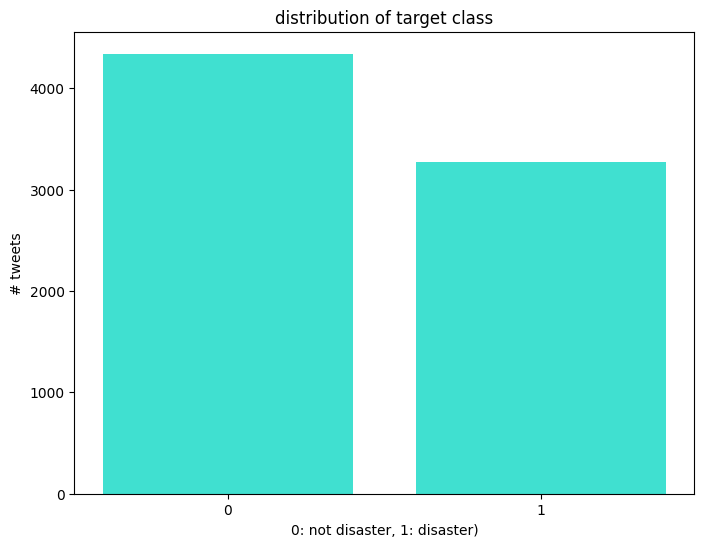

In [12]:
category_counts = df_train['target'].value_counts()
category_prop = category_counts / category_counts.sum()
print(category_prop, '\n')

# vis distribution
plt.figure(figsize = (8, 6))
plt.bar(category_counts.index,
        category_counts.values,
        color = 'turquoise')
plt.xticks([0, 1])
plt.title('distribution of target class')
plt.xlabel('0: not disaster, 1: disaster)')
plt.ylabel('# tweets')
plt.show()

In [13]:
# check for missing data
total = df_train.isnull() \
                .sum() \
                .sort_values(ascending = False)

# percent missing
percent = df_train.isnull() \
                  .sum()/df_train.isnull().count() \
                  .sort_values(ascending = False)

nulls = pd.concat([total, percent],
                  axis = 1,
                  keys = ['Total', 'Percent'])

nulls.head(df_train.shape[1])

,Total,Percent
location,2533,0.332720
keyword,61,0.008013
id,0,0.000000
text,0,0.000000
target,0,0.000000


In [14]:
# function to remove non-alphabetical characters
def remove_non_alpha(text):

   return re.sub(r'[^a-zA-Z\s]', '', (text))

In [15]:
# function to convert all to lower case
def to_lower(text):
  return text.lower()

In [16]:
# clean data
df_train['text'] = df_train['text'].apply(remove_non_alpha) \
                                   .apply(to_lower)

df_test['text'] = df_test['text'].apply(remove_non_alpha) \
                                 .apply(to_lower)

In [17]:
text = df_train['text']

# specify vectorizer
vectorizer = (TfidfVectorizer(max_features = 10000,
                              stop_words = 'english'))
# vectorize text col
train_tfidf = vectorizer.fit_transform(text)

# feature names
feature_names = vectorizer.get_feature_names_out()

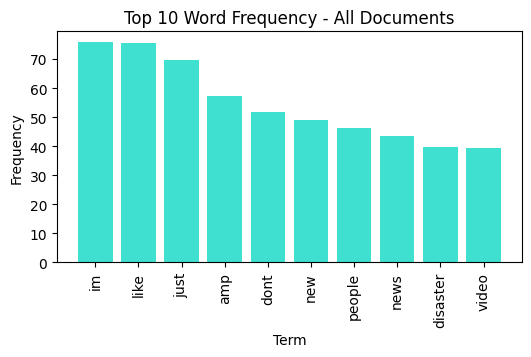

In [18]:
# word frequency - all documents
word_freq = np.sum(train_tfidf.toarray(),
                   axis = 0)
freq_all = pd.DataFrame({'Term': feature_names,
                         'Frequency': word_freq})
freq_all = freq_all.sort_values(by = 'Frequency',
                                ascending = False)

# top 10 occurring
top_all = freq_all.head(10)

# word freq
plt.figure(figsize = (6, 3))
plt.bar(top_all['Term'],
        top_all['Frequency'],
        color='turquoise')
plt.xlabel('Term')
plt.ylabel('Frequency')
plt.title('Top 10 Word Frequency - All Documents')
plt.tick_params(axis = 'x',
                rotation=90)

plt.show()

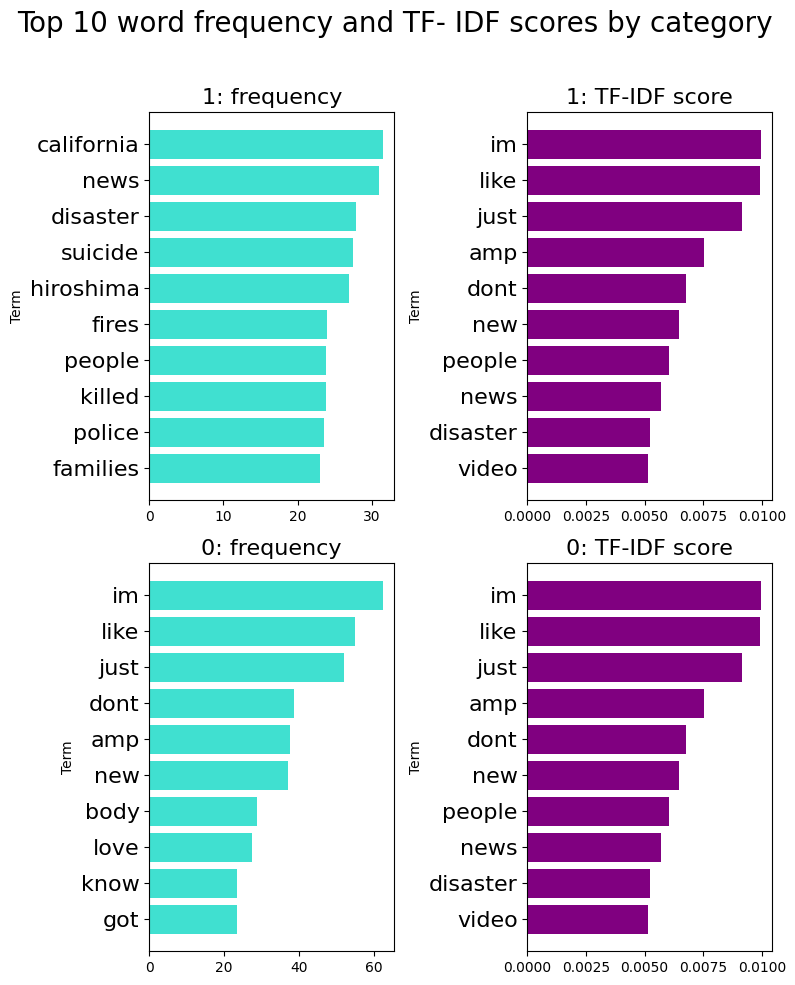

In [19]:
# subplots
fig, axes = plt.subplots(2, 2, figsize=(8, 10))
fig.suptitle('Top 10 word frequency and TF- IDF scores by category',
             fontsize = 20)

# word frequency - category
cat = df_train['target'].unique()
#print(cat)

# loop to create subplots
for i, category in enumerate(cat):

    # filter train_tfidf for category
    cat_class = df_train['target'] == category
    cat_tfidf = train_tfidf[cat_class]

    # word freq
    word_freq = np.sum(cat_tfidf.toarray(),
                       axis = 0)
    freq_df = pd.DataFrame({'Term': feature_names,
                            'Frequency': word_freq})
    freq_df = freq_df.sort_values(by = 'Frequency',
                                  ascending = False)
    # top10
    top_freq = freq_df.head(10)

    # left subplots, frequency
    ax_freq = axes[i, 0]
    ax_freq.barh(top_freq['Term'],
           top_freq['Frequency'],
           color='turquoise')
    ax_freq.set_title(f'{category}: frequency',
                      fontsize = 16 )
    #ax_freq.set_xlabel('Frequency')
    ax_freq.set_ylabel('Term')
    ax_freq.tick_params(axis = 'y',
                        labelsize = 16)
    ax_freq.invert_yaxis()

    # tfidf scores
    tfidf_scores = np.mean(train_tfidf.toarray(), axis = 0)
    tfidf_all = pd.DataFrame({'Term': feature_names,
                              'TF-IDF score': tfidf_scores})
    tfidf_all = tfidf_all.sort_values(by = 'TF-IDF score',
                                      ascending = False)

    # top 10 scores
    top_tfidf = tfidf_all.head(10)

    # right subplots, scores
    ax_tfidf = axes[i, 1]
    ax_tfidf.barh(top_tfidf['Term'],
                  top_tfidf['TF-IDF score'],
                  color = 'purple')
    ax_tfidf.set_title(f'{category}: TF-IDF score',
                       fontsize = 16)

    ax_tfidf.set_ylabel('Term')
    ax_tfidf.tick_params(axis = 'y',
                         labelsize = 16)
    ax_tfidf.invert_yaxis()

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [20]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,our deeds are the reason of this earthquake ma...,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1
2,5,NaN,NaN,all residents asked to shelter in place are be...,1
3,6,NaN,NaN,people receive wildfires evacuation orders in...,1
4,7,NaN,NaN,just got sent this photo from ruby alaska as s...,1


In [21]:
# split data
X = train_tfidf
y = df_train['target']

X_train, X_val, y_train, y_val = train_test_split(X,
                                                  y,
                                                  test_size = 0.2,
                                                  random_state = 5011)

In [35]:
# smote for imbalanced training data
smote = SMOTE(random_state = 5011)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [48]:
# model1
model1 = tf.keras.Sequential([tf.keras.layers.Embedding(input_dim = 10000,
                                                       output_dim = 128),
                             tf.keras.layers.LSTM(64),
                             tf.keras.layers.Dense(1, activation = 'sigmoid')
])

In [49]:
# model1 compile
model1.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

In [51]:
# model1 fit
clear_session()

early_stopping = EarlyStopping(monitor = 'val_loss',
                               patience = 3)

history = model1.fit(X_train_resampled,
                     y_train_resampled,
                     epochs = 10,
                     validation_data = (X_val, y_val),
                     verbose = 0,
                     callbacks  = [early_stopping])

In [52]:
history1 = pd.DataFrame(history.history)
history1.head()

,accuracy,loss,val_accuracy,val_loss
0,0.506959,0.692968,0.586343,0.684637
1,0.496811,0.693433,0.586343,0.693124
2,0.491882,0.693454,0.586343,0.690852
3,0.502899,0.693213,0.413657,0.694077


In [24]:
model2 = tf.keras.Sequential([tf.keras.layers.Embedding(input_dim = 10000,
                                                        output_dim = 128),
                              tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
                              tf.keras.layers.Dense(1, activation = 'sigmoid')])

In [25]:
model2.compile(optimizer = 'adam',
               loss = 'binary_crossentropy',
               metrics = ['accuracy'])

In [54]:
# model2 fit
clear_session()

early_stopping = EarlyStopping(monitor = 'val_loss',
                               patience = 3)


history = model2.fit(X_train_resampled,
                     y_train_resampled,
                     epochs = 10,
                     validation_data = (X_val, y_val),
                     verbose = 0,
                     callbacks  = [early_stopping])

In [55]:
history2 = pd.DataFrame(history2)
history2

,accuracy,loss,val_accuracy,val_loss
0,0.566338,0.685676,0.586343,0.684825
1,0.566338,0.684728,0.586343,0.679670
2,0.566338,0.685265,0.586343,0.679921
3,0.566338,0.684782,0.586343,0.681429
4,0.566338,0.684733,0.586343,0.679581
5,0.566338,0.684851,0.586343,0.678619
6,0.566338,0.684541,0.586343,0.681187
7,0.566338,0.684691,0.586343,0.678579
8,0.566338,0.684950,0.586343,0.681141
9,0.566338,0.684789,0.586343,0.678665


class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1, dropout_rate=0.5):
        super(LSTMModel, self).__init__()

        # LSTM layer
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

        # Dropout layer for regularization
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        # x is of shape (batch_size, seq_len, input_size)

        # LSTM layer
        lstm_out, (hn, cn) = self.lstm(x)

        # Use the output of the last LSTM time step (last hidden state)
        lstm_out = lstm_out[:, -1, :]  # Shape: (batch_size, hidden_dim)

        # Pass through dropout and fully connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)

        return out

# Model hyperparameters section
hyperparameters = {
    'input_dim': X_train_combined.shape[1],  # Number of features (after TF-IDF + normalized features)
    'hidden_dim': 64,                       # Number of features in the hidden state
    'output_dim': 2,                        # Number of classes (adjust based on your problem)
    'num_layers': 2,                        # Number of LSTM layers
    'dropout_rate': 0.5,                    # Dropout rate for regularization
    'learning_rate': 0.001                  # Learning rate for optimizer
}

# Instantiate the model using the hyperparameters
model = LSTMModel(
    input_dim=hyperparameters['input_dim'],
    hidden_dim=hyperparameters['hidden_dim'],
    output_dim=hyperparameters['output_dim'],
    num_layers=hyperparameters['num_layers'],
    dropout_rate=hyperparameters['dropout_rate']
)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=hyperparameters['learning_rate'])